In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR= '/content/drive/MyDrive'
WORKING_DIR= '/content/drive/MyDrive'

In [39]:
#Image Features
model = VGG16()
#Re-structure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


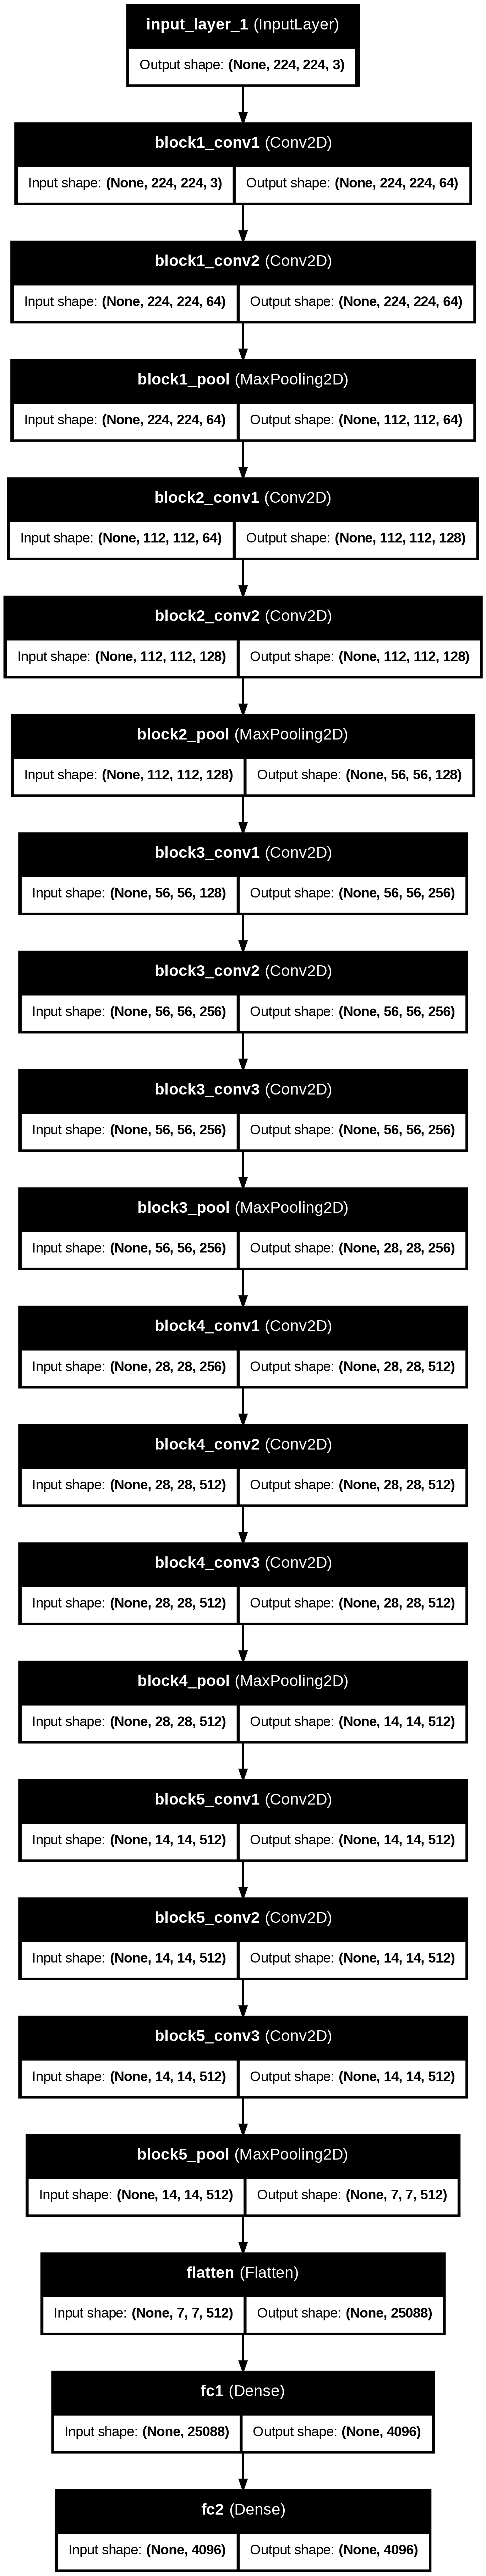

In [40]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
#extract features from Image -
# features = {}
# directory = os.path.join(BASE_DIR, 'Flicker8k_Dataset')

# for img_name in tqdm(os.listdir(directory)):
#   img_path = directory + '/' + img_name
#   image = load_img(img_path, target_size=(224, 224))
#   image = img_to_array(image)
#   image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#   image = preprocess_input(image)
#   feature = model.predict(image, verbose=0)
#   image_id = img_name.split('.')[0]
#   features[image_id] = feature

In [6]:
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
#Load the captions
with open(os.path.join(BASE_DIR, 'Flickr8k.token.txt'), 'r') as f:
  captions_doc = f.read()

In [9]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
  tokens = line.split('#')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = " ".join(caption)
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [10]:
print(len(mapping))

8092


In [11]:
mapping['1000268201_693b08cb0e']

['0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1\tA girl going into a wooden building .',
 '2\tA little girl climbing into a wooden playhouse .',
 '3\tA little girl climbing the stairs to her playhouse .',
 '4\tA little girl in a pink dress going into a wooden cabin .']

In [12]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]', '')
      caption = caption.replace('\s+', ' ')
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i] = caption

In [13]:
clean(mapping)

In [14]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [37]:
with open("captions_mapping.pkl", "wb") as file:
    pickle.dump(mapping, file)

In [15]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [16]:
len(all_captions)

40460

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8485


In [19]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [20]:
with open("vocabulary.pkl", "wb") as f:
    pickle.dump(tokenizer.word_index, f)

In [21]:
max_len = max(len(caption.split()) for caption in all_captions)
max_len

34

In [22]:
image_id = list(mapping.keys())
split = int(len(image_id)*0.90)
print(split)
train = image_id[:split]
test = image_id[split:]

7282


In [23]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0  # Counter to keep track of batch size

    while True:  # Infinite loop for Keras generators
        for key in data_keys:
            # Skip if the key is missing in features
            if key not in features:
                print(f"Warning: Key '{key}' not found in features. Skipping this item.")
                continue

            captions = mapping[key]

            # Process each caption associated with the image
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs for each caption
                for i in range(1, len(seq)):
                    # Split into input (in_seq) and output (out_seq) pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append to our batch lists
                    X1.append(features[key][0])  # Image feature vector
                    X2.append(in_seq)            # Text input sequence
                    y.append(out_seq)            # Output word

                    # Increment batch counter
                    n += 1
                    # Yield the batch when batch size is reached
                    if n == batch_size:
                        yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                        X1, X2, y = list(), list(), list()  # Reset for the next batch
                        n = 0  # Reset batch counter

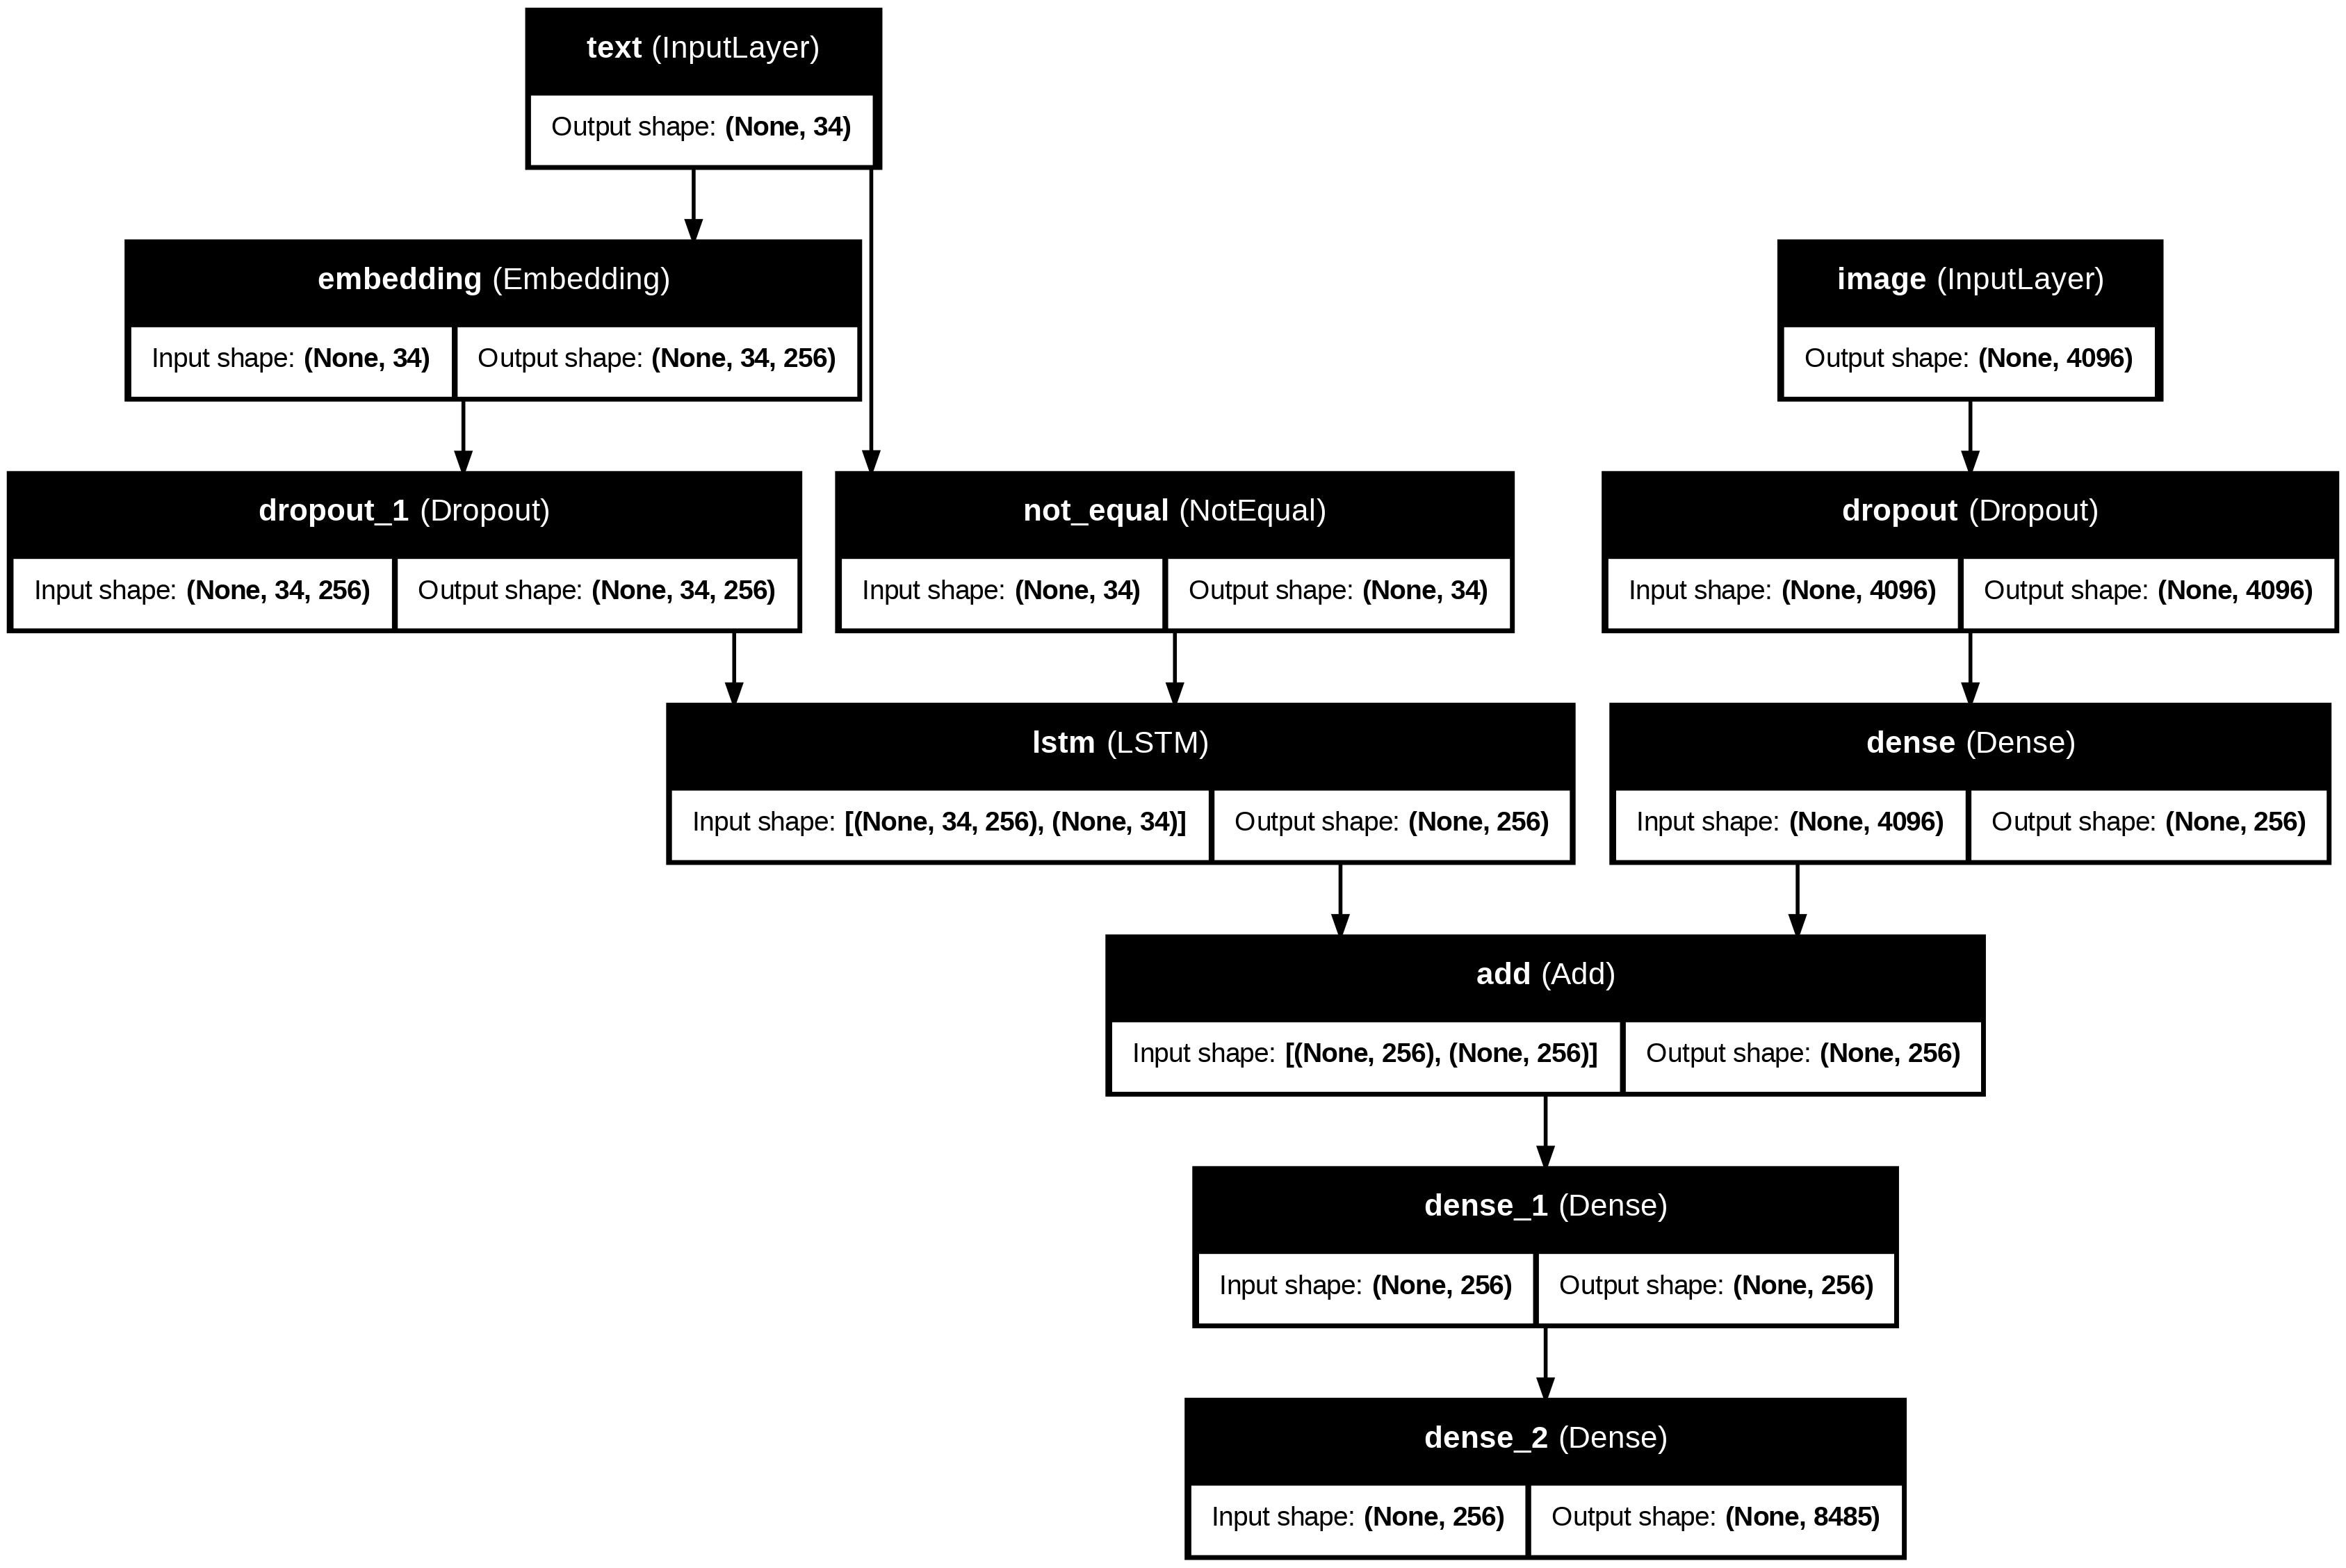

In [24]:

inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_len,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
epochs = 100
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_len, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - loss: 6.7210
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 216ms/step - loss: 5.0736
227/227 ━━━━━━━━━━━━━━━━━━━━ 48s 211ms/step - loss: 4.7541
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 216ms/step - loss: 4.4194
227/227 ━━━━━━━━━━━━━━━━━━━━ 48s 211ms/step - loss: 4.1790
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 218ms/step - loss: 3.8750
227/227 ━━━━━━━━━━━━━━━━━━━━ 48s 209ms/step - loss: 3.5832
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 215ms/step - loss: 3.5315
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - loss: 3.2475
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 215ms/step - loss: 3.0897
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 222ms/step - loss: 2.9323
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 217ms/step - loss: 2.8301
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 215ms/step - loss: 2.5832
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - loss: 2.4632
227/227 ━━━━━━━━━━━━━━━━━━━━ 48s 213ms/step - loss: 2.3894
227/227 ━━━━━━━━━━━━━━━━━━━━ 48s 210ms/step - loss: 2.2678
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 216ms/step - loss: 2.25

In [29]:
model.save('RNNmodelkeras.keras')

In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length,padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

100%|██████████| 810/810 [14:25<00:00,  1.07s/it]


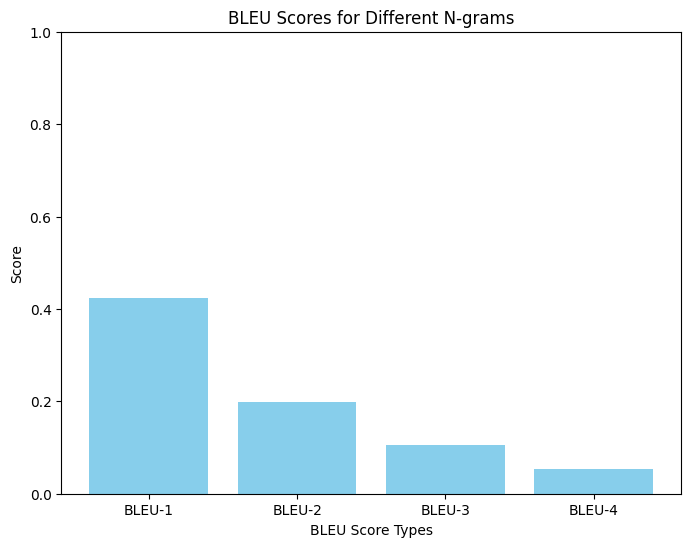

In [32]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Calculate BLEU scores
def calculate_bleu_scores(model, test, mapping, features, tokenizer, max_len):
    actual, predicted = list(), list()

    for key in tqdm(test):
        # Get actual caption
        captions = mapping[key]
        # Predict the caption for the image
        y_pred = predict_caption(model, features[key], tokenizer, max_len)
        # Split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # Append to the lists
        actual.append(actual_captions)
        predicted.append(y_pred)

    # Calculate BLEU scores for different n-grams
    bleu_scores = {
        'BLEU-1': corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)),
        'BLEU-2': corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)),
        'BLEU-3': corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)),
        'BLEU-4': corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)),
    }

    return bleu_scores

# Plot and save BLEU scores
def plot_and_save_bleu_scores(bleu_scores, filename="bleu_scores.png"):
    # Extract the BLEU scores
    labels = list(bleu_scores.keys())
    scores = list(bleu_scores.values())

    # Plot
    plt.figure(figsize=(8, 6))
    plt.bar(labels, scores, color='skyblue')
    plt.title("BLEU Scores for Different N-grams")
    plt.xlabel("BLEU Score Types")
    plt.ylabel("Score")
    plt.ylim(0, 1)

    # Save the plot as an image
    plt.savefig(filename, format='png')
    plt.show()

# Calculate BLEU scores
bleu_scores = calculate_bleu_scores(model, test, mapping, features, tokenizer, max_len)

# Plot and save BLEU scores
plot_and_save_bleu_scores(bleu_scores, filename="bleu_scores.png")


In [33]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Flicker8k_Dataset", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_len)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs on pavement moving toward each other endseq


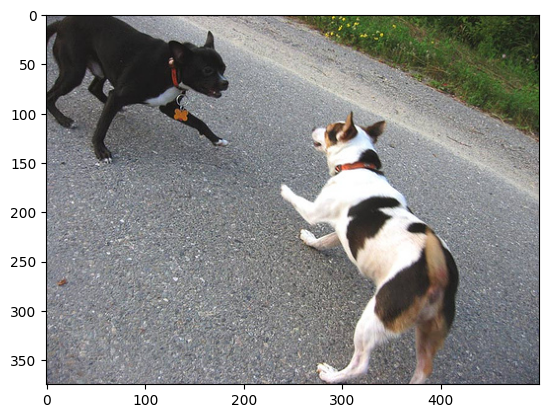

In [36]:
generate_caption('1001773457_577c3a7d70.jpg')